Here we have some code to read the seismic data, filter to look at the seismic wave periods we're interested in, and then extract the amplitude

In [1]:
# The coding language we're using is Python, and it has a bunch of built-in functions.  But there are also other sets
# of functions we need to call.  We'll import some of those functions here so that we can acesss them
import obspy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# these are files with data we'd like to read
fls = ['UR.AQ07.00.HHZ.D.2020.011','UR.AQ07.00.HHZ.D.2020.013']

In [3]:
# let's read all the files
st = obspy.read(fls[0])
for fname in fls[1:]:
    st=st+obspy.read(fname)
st.merge();

In [4]:
# some adjustments to the data, in case there are gaps
if isinstance(st[0].data,np.ma.masked_array):
    data = st[0].data
    msk = st[0].data.mask
    data[msk] = np.interp(np.where(msk)[0],np.where(~msk)[0],data[~msk])

In [5]:
# and find out a bit more about the data
print(st)

1 Trace(s) in Stream:
UR.AQ07.00.HHZ | 2020-01-11T00:00:00.000000Z - 2020-01-13T23:59:59.990000Z | 100.0 Hz, 25920000 samples


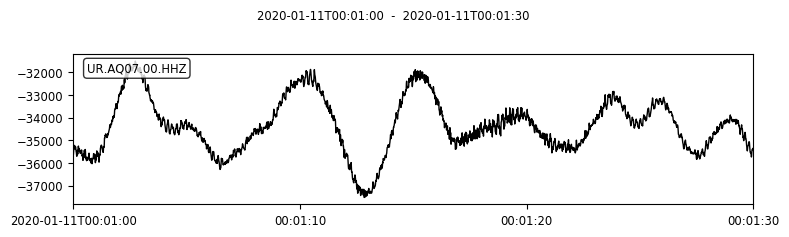

In [6]:
# that's quite a long seismogram---a whole day of data with 100 observations per second
# let's plot just a portion of it
tref=st[0].stats.starttime+60
st.plot(starttime=tref,endtime=tref+30);

In [7]:
st.detrend()
st.taper(max_length=10,max_percentage=0.5)
st.filter('bandpass',freqmin=1,freqmax=10,zerophase=True)

1 Trace(s) in Stream:
UR.AQ07.00.HHZ | 2020-01-11T00:00:00.000000Z - 2020-01-13T23:59:59.990000Z | 100.0 Hz, 25920000 samples

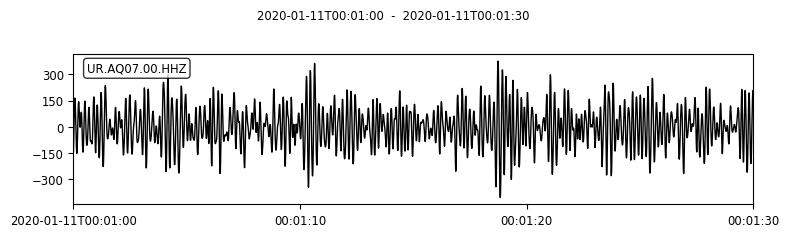

In [8]:
# and plot again
st.plot(starttime=tref,endtime=tref+30);

Now we'd like to get the envelope, or amplitude, of the seismogram in this time period

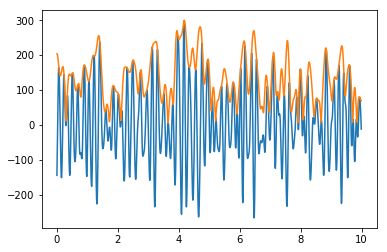

In [9]:
# this computes the envelope
data_envelope = obspy.signal.filter.envelope(st[0].data)

i1=int((tref-st[0].stats.starttime)/st[0].stats.delta)
i2=i1+10*100
plt.plot(st[0].times()[i1:i2]-st[0].times()[i1],st[0].data[i1:i2])
plt.plot(st[0].times()[i1:i2]-st[0].times()[i1],data_envelope[i1:i2])

In [10]:
# and we'll save the values like the original seismogram formatting so that we can manipulate them more easily
stenv = obspy.Stream(st[0].copy())
stenv[0].data = data_envelope

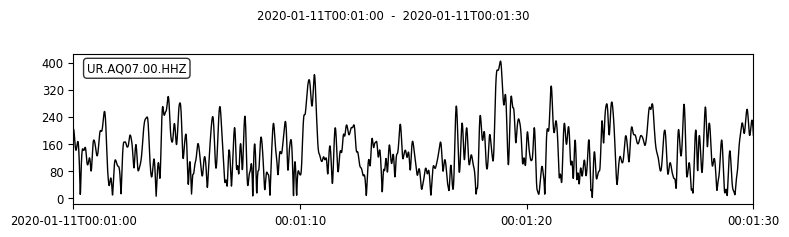

In [11]:
# and plot to see what we get
stenv.plot(starttime=tref,endtime=tref+30);

So this has worked--we now have the seismogram amplitude through time.  But it's going to be a bit hard to work with, since we have a sample every 0.01 seconds, and there are very high-frequency oscillations.  Ocean waves don't change that quickly.  So let's look at longer period osicllations and then downsample so that we have an observation every half an hour.

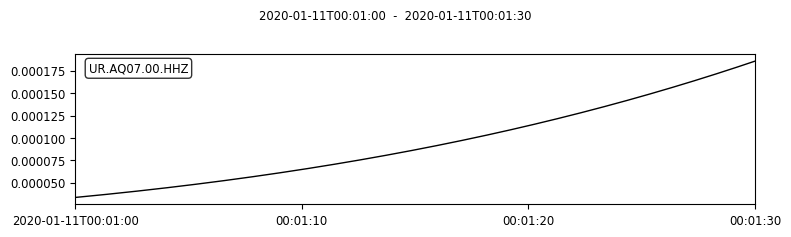

In [12]:
# first we filter, to look at changes in amplitude on timescales of 2 hours or more
stenv.filter('lowpass',freq=1/(2*3600))

# note that when we look at a short time interval, the amplitude looks constant
stenv.plot(starttime=tref,endtime=tref+30);

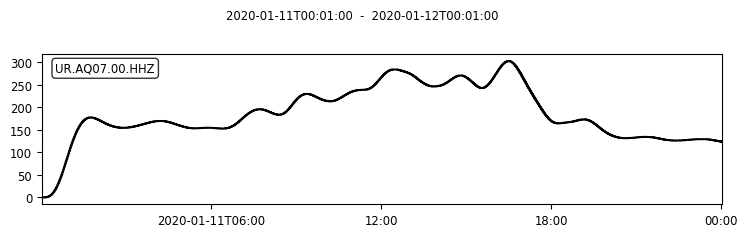

In [13]:
# but if we look at a longer time window, we can still see the oscillations
stenv.plot(starttime=tref,endtime=tref+86400);

In [14]:
# and now let's downsample, so that we have a sample every half an hour
# note that this amount of data is more manageable
nval=int(np.round(1800/stenv[0].stats.delta))
stenv.decimate(factor=nval,no_filter=True)

1 Trace(s) in Stream:
UR.AQ07.00.HHZ | 2020-01-11T00:00:00.000000Z - 2020-01-13T23:30:00.000000Z | 1800.0 s, 144 samples

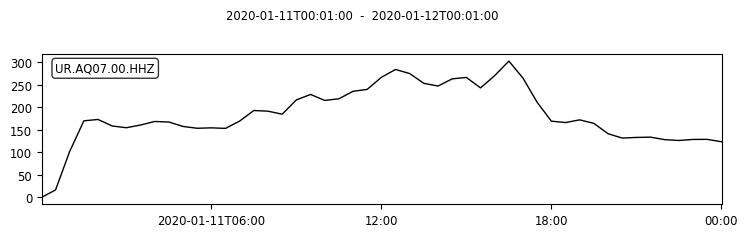

In [15]:
# the resampled data provides the same information as before
stenv.plot(starttime=tref,endtime=tref+86400);